# Photonic Crystal Hamiltonian Inference
###       Final Project, Group 5, PHYS201, Harvard University, Spring 2023
####      Group Members: Thi Huong Thao Dinh, Fan Du, Yiting Huang

## Background
Photonic crystals (PhC) are micro/nano artificial atoms composed of periodically perturbed refractive indices dielectric material, which can manipulate the propagation of electromagnetic (EM) waves in a similar manner to how actual crystals manipulate electron waves. The periodic symmetry and Maxwell equations guarantee that the eigenmodes of EM waves can be held in PhC are represented by photonic band structures. One popular method to analyze the band structures of photonic crystals is to apply the Hamiltonian formalism, however, the method to select Hamiltonian basis has been left unrevealed in the majority of related papers. This will be the main purpose of our project.

## Generative Model: The Hamiltonian Matrix
The Hamiltonian matrix consists of frequencies of uncoupled slab modes on chosen momentum basis and the coupling intensity parameters between them. The former contribute to diagonal elements in the matrix, while the latter contribute to off diagonal terms. At a single momentum configuration $(k_x,k_y)$, the Hamiltonian matrix can be constructed and diagonolized to obtain the eigen frequencies of Bloch wave in photonic crystal. Due to the C4 symmetry of our square lattice, the allowed basis sizes are 5, 9, 13,...

Right now, this package allows you to infer the coupling parameters in a 5 basis model: 5 Bloch waves at $\Gamma$ point and its four surrounding symmetric points in $k-$space, whoses interaction can be described by 6 coupling parameters.

![title](reference_img/5-basis-doodle.png)

$U_{10},U_{11}$ and $U_{20}$ represent couplings between Bloch waves with some momentum difference as shown in figure above, $\epsilon_i (i = 1,2,3,4)$ being the energy of the slab mode at each basis. Let $P_1$ be the $\Gamma$ point, $P_2,P_3,P_4,P_5$ be the 4 points surrounding it by a clock-wise order starting at the point below the $\Gamma$ point. If we describe the model in the basis of $\{ P_1,P_2,P_3,P_4,P_5\}$, then the corresponding Hamiltonian matrix is:
$$ H =  \begin{pmatrix} \epsilon_0 & U_{10}& U_{10}& U_{10}& U_{10} \\ U_{10}& \epsilon_1 & U_{11}& U_{20}& U_{11} \\ U_{10}& U_{11}& \epsilon_2 & U_{11}& U_{20} \\ U_{10}& U_{20}&U_{11}& \epsilon_3 & U_{11}\\ U_{10}& U_{11}&U_{20}& U_{11}  & \epsilon_4  \end{pmatrix}$$

The matrix is inherently diagonalizable and has the eigenvalues $\{ e_0,e_1,e_2,e_3,e_4\}$. 

Considering the properties of experimental data, a modification and simplification is done to this model. Firstly, we chose to infer spectra at descret $k$ points along $\Gamma M$ symmetry axis in reciprocal space. So four frequencies of non-gamma basis are degerated to two values, define $\epsilon_x = \epsilon_1 = \epsilon_4, \epsilon_y = \epsilon_2 = \epsilon_3$. Secondly, the measurment is near $\Gamma$, where $|k| < 0.1 |\Gamma M|$. So the slab mode energy at $\Gamma$ basis is very low comparing with other four, which is safe to be ignored. Therefore, we get the reduced Hamiltonian matrix 
$$ H_{reduced} =  \begin{pmatrix} \epsilon_x & U_{11}& U_{20}& U_{11} \\ U_{11}& \epsilon_y & U_{11}& U_{20} \\ U_{20}&U_{11}& \epsilon_y & U_{11}\\ U_{11}&U_{20}& U_{11}  & \epsilon_x  \end{pmatrix}$$

And the eigenvalues $\{e_1,e_2,e_3,e_4\}$ represent 4 energy bands of the photonic crystal.

### Multiple Lorentzian Peak Model of the energy spectrum

In real measurement, 4 energy bands of the photonic crystals appear as four peaks in the single k frequency-intensity spectrum. Therefore, our statistical model for the energy spectrum is a multiple Lorentzian peak model where the peaks are centered at $\{C_1,C_2,C_3,C_4\}$.  The background $A_0$, amplitudes of four peaks $A_1, A_2, A_3, A_4$ and the peak quality factors $Q_1, Q_2, Q_3, Q_4$ are the nuisance parameters that we will marginalize over.

$$ \mu_i = A_0 + \sum_{j=1}^4 \frac{A \cdot W_j^2} {(W_j^2 + (x_i-C_j)^2)} $$

where $W_i$ is the half width at half maximum (HWHM) of Lorentz peak, $Q_i = C_i/W_i$.

We will discuss the priors for each type of parameter below.

For the coupling parameters $U_{11}$ and $U_{20}$, we have prior knowledge of their means values based on the electromagnetic field overlap of different slab modes and their variances based on previous research result. Moreover, there are no physical boundaries for these coupling parameters. Thus, we use the normal distribution as priors for $U_{11}$ and $U_{20}$. 

For the peak background, heights and quality factors, they are all required to be positive. We can estimate the mean value of peak heights as the typical brightness of bands on CCD pictures that are not saturated. The mean value of peak quality factors can be extracted from numerical simulation of the same system. Thus, we set exponential distribution for priors of peak heights (including background intensity) and quality factors.

Regarding the frequencies of initial slab modes, we need to ensure strictly a physical restriction $\epsilon_x > \epsilon_y$. Therefore, we define $\epsilon_0 = (\epsilon_x+\epsilon_y)/2$ and $d\epsilon = (\epsilon_x-\epsilon_y)/2$. We set $\epsilon_0$ and $d\epsilon$ as parameters with a uniform distribution, whose boundaries come from the range of frequencies used in the measurement.

Lastly, we assign a normal likelihood for each data point in the spectrum. The likelihood mean is $\mu_i$, while the likelihood standard deviation $\sigma_i$ is treated as additional inferred parameter. $\sigma_i$ cannot be estimated directly during the measurement because the typical noises from CCD or laser fluctuation are negligible compared to the systematic uncertainty from four spectra measured for each k-point. Note that due to C4 symmetry, the spectra obtained from a k-point and its other three symmetric counterparts are considered as four spectra of the same k-point. This systematic uncertainty $\sigma_i$ can be written as $\sigma_i = s \cdot \sqrt{y_i}$, where $s$ is a nuisance scaling parameter. This scaling relationship is often used to estimate the uncertainty in the measured intensity: the photon counts' uncertainty is proportional to the square root of the counts themselves. We know typical value of $s$ and that $s$ is positive , so we can assign an exponential prior distribution to $s$.

In summary, the statistical model
\begin{aligned}
y_i & \sim \text{Normal} (\mu_i,\sigma_i) \\
\mu_i & = A_0 + \sum_{j=1}^4 \frac{A \cdot W_j^2} {(W_j^2 + (x_i-C_j)^2)}\\
C_j &= C_j(U_{11},U_{20},\epsilon_0, d\epsilon) \text{ via Hamiltonian matrix diagonalization}\\
W_j &= C_j/Q_j\\
U_{11}  & \sim \text{Normal} (U_{\text{11 mean}},U_{\text{11 std}}) \\
U_{20}  & \sim \text{Normal} (U_{\text{20 mean}},U_{\text{20 std}})\\
\epsilon_0   & \sim \text{Uniform}  (\epsilon_{\text{0 min}},\epsilon_{\text{0 max}})\\
d\epsilon   & \sim \text{Uniform}  (d\epsilon_{\text{min}},d\epsilon_{\text{max}})\\
A_0 & \sim \text{Exponential}  (A_{\text{0 mean}})  \\
A_j & \sim \text{Exponential}  (A_{j \text{mean}}) \\
Q_j & \sim \text{Exponential}  (Q_{j\text{mean}})\\
\sigma_i &= s \cdot  \sqrt{y_i} \\
s &\sim \text{Exponential} (s_{\text{mean}})
\end{aligned}





## Using the photonic-hamiltonian package

### Load the data file

Before using the package, please make sure that the data is converted into .nc format

Our io_data.py script provides the function which exports the data in .nc format into an xarray with data labels 'normf', 'y1', 'y2', 'y3', 'y4', which indicates four repeating measurement results

In [6]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pytensor
import seaborn as sns

from photonic_hamiltonian.inference import io_data
#load an example data file, data courtersy: Fan Du
real_data = io_data.load_data('photonic_hamiltonian/data/expdata_chip19_GM0p0525.nc')

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/hyt/Documents/GitHub/Hamiltonian-photonic-crystal/photonic_hamiltonian/data/expdata_chip19_GM0p0525.nc'

We can plot this data to visualize how the four peaks look like in a real measurement

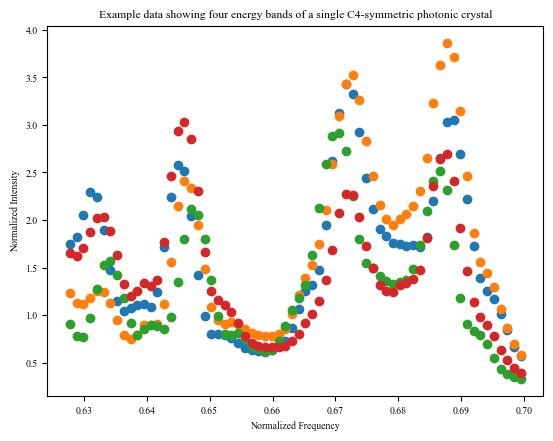

In [12]:
freq = real_data['normf'].to_numpy()
intensity = np.array([real_data[name].to_numpy() for name in ['y1', 'y2', 'y3', 'y4']])
plt.plot(freq, intensity.T, 'o')
plt.xlabel('Normalized Frequency')
plt.ylabel('Normalized Intensity')
plt.title('Example data showing four energy bands of a single C4-symmetric photonic crystal')
plt.show()

### Inference fit using pymc

In the package, the Model.py script has two functions: Hamiltonian_model and prediction_model

$\textbf{Hamiltonian_model(data, prior_bounds)}$ function:
* It is used to define, diagonalize the Hamiltonian matrix, and build a multi Lorentzian peak model from the matrix's eigenvalues. You can use this pymc model for sampling, plotting the posterior, finding the maximum a posteriori (MAP) point, or estimating the parameters from the mean of posterior distribution.
* Its input parameters are data extracted and formatted by io.py, and a dictionary which maps parameters' names ('u11', 'u20', 'e0', 'de', 'A0', 'A1', 'A2', 'A3' , 'A4', 'Q1', 'Q2', 'Q3', 'Q4', 'sigma_y') to their corresponding prior types and coefficients.

$\textbf{prediction_model(theta, freq)}$ function:
 * It calculates the fitted intensity for a given set of fitting parameters
 * Its input parameters are the normalized frequency and a list of fitting parameters in the order [u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4]

In [4]:
from photonic_hamiltonian.inference import Model

#### Inference on simulated data

To test if running our model gives a reasonable result for parameter estimation, we first generate a simulated data with given values for all the parameters

Text(0.5, 1.0, 'Simulated data showing four energy bands of a single C4-symmetric photonic crystal')

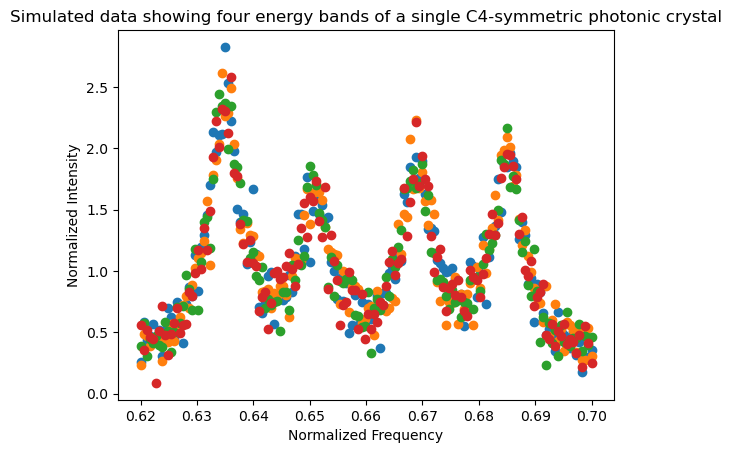

In [7]:
# Create simulated data
N = 150
simu_normf = np.linspace(0.62,0.70,N)    # create normalized frequency, "x" variable 

#set all hamiltonian parameters as some constants
u11 = 0.008
u20 = 5e-5
e0 = 0.66
de = 0.015
A0 = 0.3
[A1, A2, A3, A4] = [1.9, 1.2, 1.5, 1.6]
[Q1, Q2, Q3, Q4] = [180, 200, 210, 220]
theta = [u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4]
#create normalized intensity
line = Model.prediction_model(theta, simu_normf)

#create noise ratio
sigma_noise = 0.15

#create data array
simu_data = xr.Dataset(data_vars = {'y1': ('normf', line + np.sqrt(line)*np.random.normal(0, sigma_noise, N) ),
                                    'y2': ('normf', line + np.sqrt(line)*np.random.normal(0, sigma_noise, N)  ),
                                    'y3': ('normf', line + np.sqrt(line)*np.random.normal(0, sigma_noise, N) ),
                                    'y4': ('normf', line +np.sqrt(line)*np.random.normal(0, sigma_noise, N)  )},
                     coords = { 'normf': simu_normf})

#plot the simulated data to visualize the four peaks
simu_intensity = np.array([simu_data[name].to_numpy() for name in ['y1', 'y2', 'y3', 'y4']])
plt.plot(simu_normf, simu_intensity.T, 'o')
plt.xlabel('Normalized Frequency')
plt.ylabel('Normalized Intensity')
plt.title('Simulated data showing four energy bands of a single C4-symmetric photonic crystal')

From the raw data, we can guess some reasonable bounds for our priors.

In [12]:
#guess the prior bounds
Q = [1/200]
A = [1/1.6]
simu_priors = {'u11':('Normal', [0.008, 0.0002]),
               'u20':('Normal', [0.001, 0.0001]),
               'e0':('Uniform', [0.65, 0.67]),
               'de':('Uniform', [0.01, 0.02]),
               'A0':('Exponential', [1/0.3]),
               'A1':('Exponential', A),
               'A2':('Exponential', A),
               'A3':('Exponential', A),
               'A4':('Exponential', A),
               'Q1':('Exponential', Q ), 
               'Q2':('Exponential', Q ),
               'Q3':('Exponential', Q ),
               'Q4':('Exponential', Q ),
               'sigma_y':('Exponential', [1/0.2])}

#create the model 
simu_ham_model = Model.Hamiltonian_model(simu_data, simu_priors)

NameError: name 'simu_data' is not defined

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4, sigma_y]


Sampling 4 chains for 1_000 tune and 300 draw iterations (4_000 + 1_200 draws total) took 231 seconds.


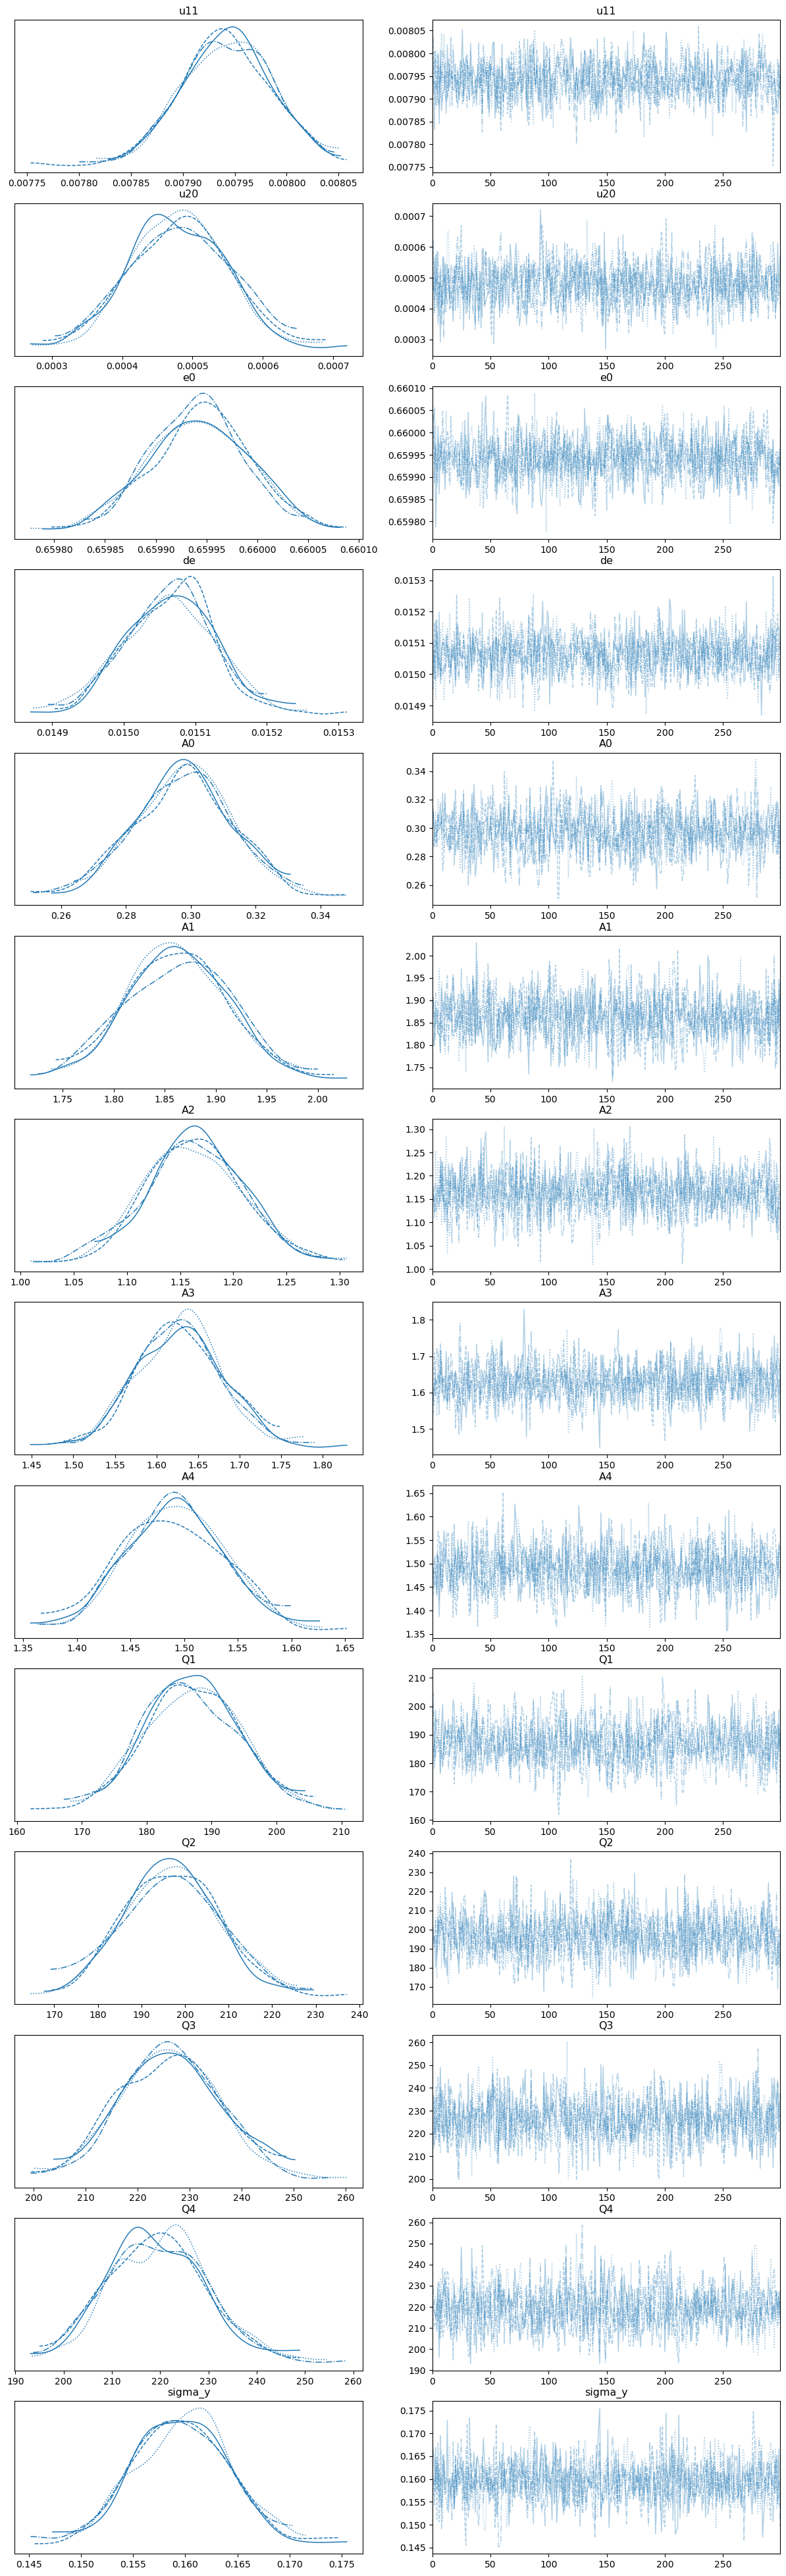

In [6]:
with simu_ham_model:
    simu_idata = pm.sample(300)

az.plot_trace(simu_idata, figsize=(15,50));

In [7]:
#summary the fitting results
simu_summary = az.summary(simu_idata,round_to=8)
display(simu_summary)

mean         sd      hdi_3%     hdi_97%  mcse_mean  \
u11        0.007942   0.000043    0.007867    0.008023   0.000001   
u20        0.000481   0.000069    0.000342    0.000596   0.000002   
e0         0.659942   0.000048    0.659849    0.660025   0.000001   
de         0.015064   0.000062    0.014951    0.015179   0.000002   
A0         0.297770   0.014908    0.269489    0.324814   0.000428   
A1         1.862913   0.050150    1.761381    1.951534   0.001362   
A2         1.164001   0.045452    1.070667    1.241996   0.001164   
A3         1.627492   0.051529    1.539830    1.725250   0.001369   
A4         1.490876   0.046367    1.412044    1.580823   0.001231   
Q1       187.038243   7.428435  173.005654  201.204629   0.225509   
Q2       196.915022  11.026362  175.992056  217.075525   0.280613   
Q3       226.190666   9.584604  209.515910  244.738366   0.251634   
Q4       219.532577  10.263857  200.952783  238.887733   0.309476   
sigma_y    0.159620   0.004631    0.150957    0.168138   0.000118   

              mcse_sd     ess_bulk     ess_tail     r_hat  
u11      8.300000e-07  1332.235733  1062.692588  1.001544  
u20      1.330000e-06  1418.773574   904.116551  1.001409  
e0       9.300000e-07  1337.551324   971.135425  1.004638  
de       1.180000e-06  1371.516126  1058.603518  0.999139  
A0       3.025300e-04  1215.203330   915.486702  0.999300  
A1       9.633000e-04  1353.713017   771.587376  1.000995  
A2       8.231300e-04  1510.459516   982.771498  1.002251  
A3       9.680400e-04  1423.252500   999.601222  0.997976  
A4       8.703700e-04  1431.493989   957.635143  1.002743  
Q1       1.596201e-01  1086.017385   886.900031  0.999713  
Q2       1.984612e-01  1535.115638   899.064516  0.999296  
Q3       1.782538e-01  1450.525166  1007.227631  0.998575  
Q4       2.192368e-01  1103.911867  1029.150471  1.000668  
sigma_y  8.367000e-05  1534.924120   807.621534  1.002844

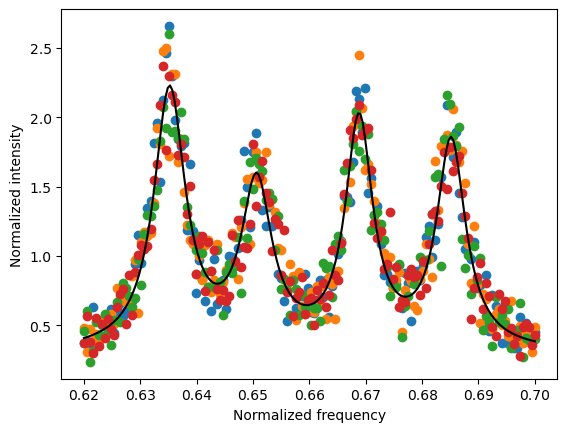

In [8]:
#plot data with the fitting curve using mean of the parameters' posterior distribution
u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4, sigma_y = simu_summary['mean'].values
simu_theta = [u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4]
model_predictions = Model.prediction_model(simu_theta, np.linspace(0.62,0.70,200))
plt.xlabel("Normalized frequency")
plt.ylabel("Normalized intensity")
plt.plot(simu_normf, simu_intensity.T, 'o')
plt.plot(np.linspace(0.62,0.70,200), model_predictions, 'k');

We can see that all these marginalized posteriors are peaked at the correct values of parameters that we used to generate the simulated data. Thus, our package works reasonably well with the simulated data.

#### Inference on real data with proper priors

Similar to what we did with the simulated data, we need to look at the raw data, guess the typical values for peak parameters and then sample with generative model.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4, sigma_y]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 94 seconds.


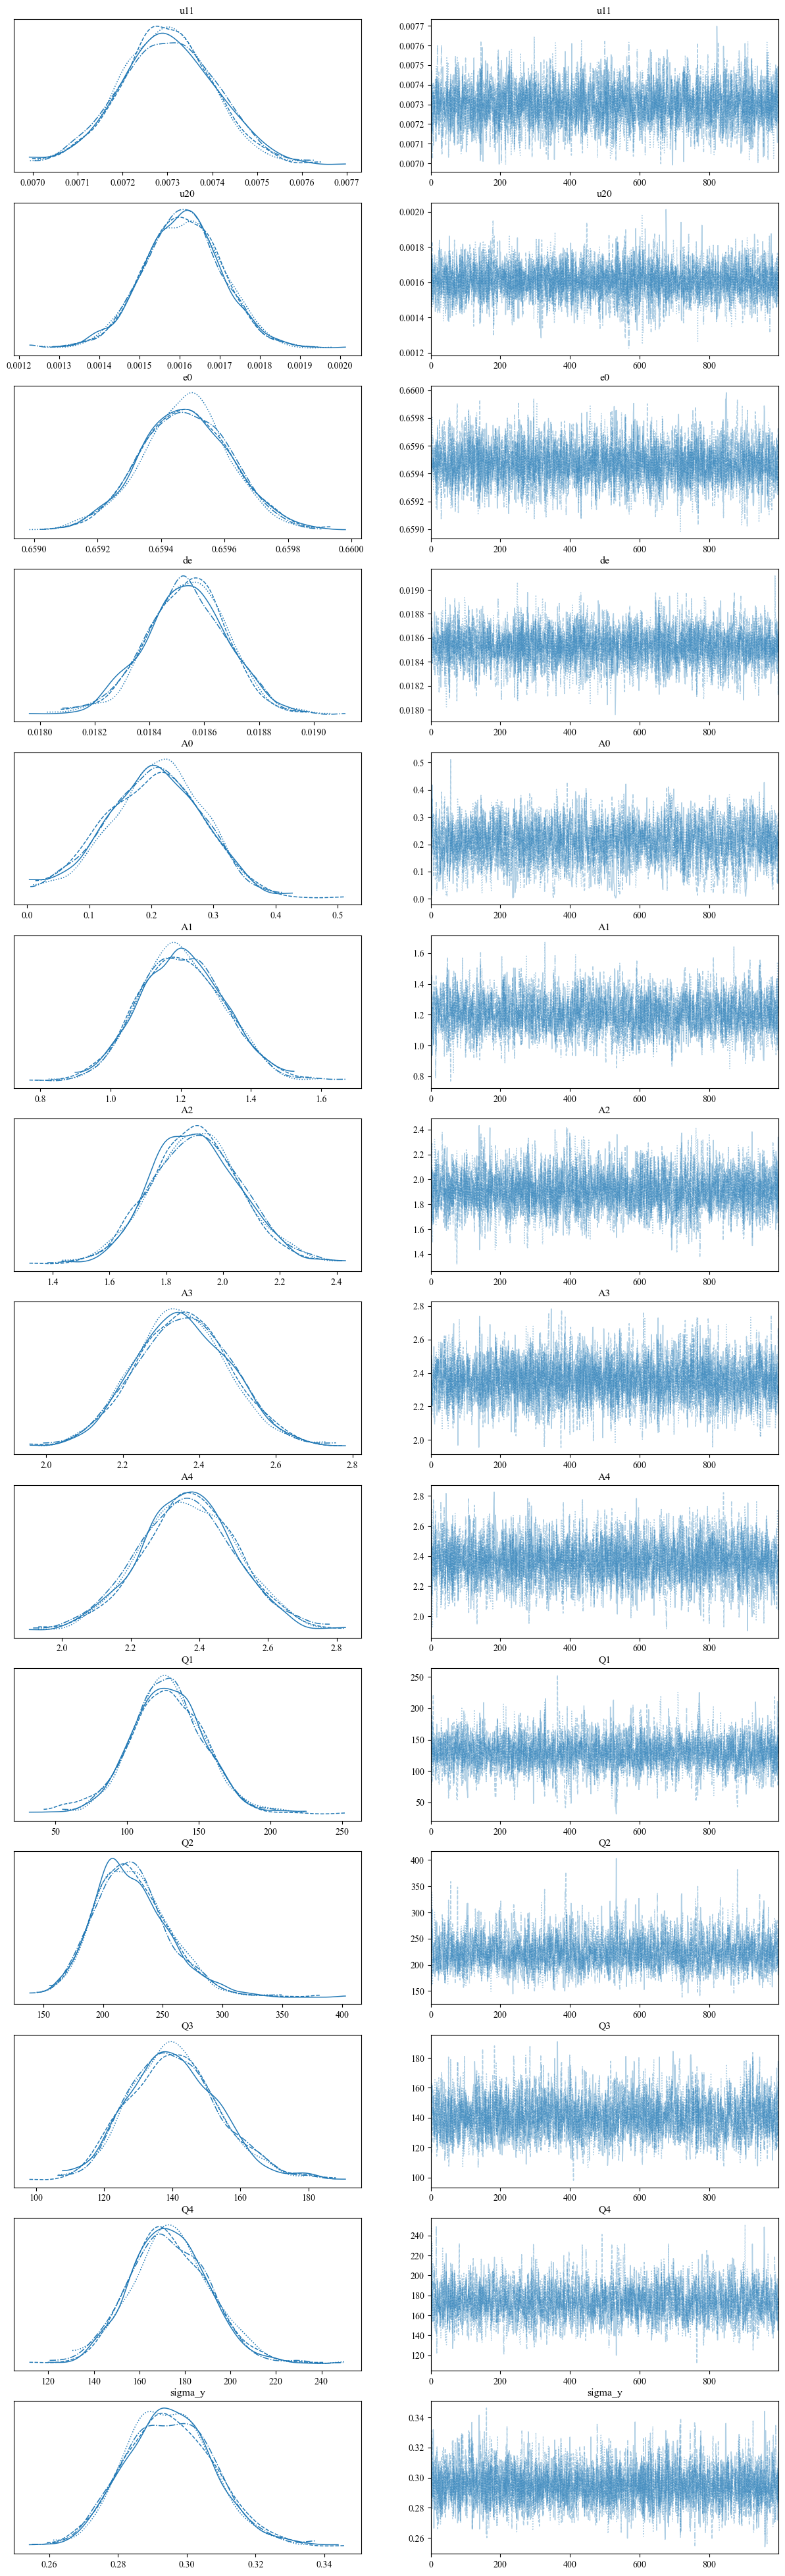

In [13]:
## attempt with more physical priors
Q = [1/180]
A = [1/1.6]
priors_2 = {'u11':('Normal', [0.0074, 0.0002]),
               'u20':('Normal', [0.0017, 0.0001]),
               'e0':('Uniform', [0.65, 0.67]),
               'de':('Uniform', [0.005, 0.025]),
               'A0':('Exponential', [1/0.3]),
               'A1':('Exponential', A),
               'A2':('Exponential', A),
               'A3':('Exponential', A),
               'A4':('Exponential', A),
               'Q1':('Exponential', Q), 
               'Q2':('Exponential', Q),
               'Q3':('Exponential', Q),
               'Q4':('Exponential', Q),
               'sigma_y':('Exponential', [1/0.25])}

#create the model 
ham_model = Model.Hamiltonian_model(real_data, priors_2)
with ham_model:
    idata = pm.sample(tune=500,draws=1000,chains=4,return_inferencedata=True,)

az.plot_trace(idata, figsize=(15,50));

## Use cells below to plot

/var/folders/lc/3fp8jjr53j7gmwk4v8_1s_vr0000gn/T/ipykernel_2158/3854722413.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(np.linspace(0.62,0.70,200), model_predictions,'k', linewidth = 1,color = 'purple',alpha = 0.3)


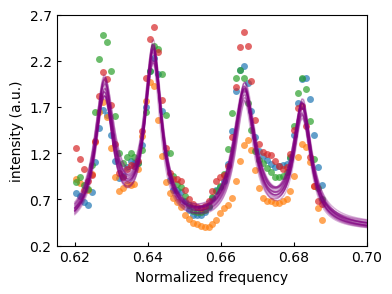

In [15]:
import random
from photonic_hamiltonian.inference import io_data
#summary the fitting results
### import raw data and fitting result idata
### expdata_chip18_GM0p0625   and    expdata_chip19_GM0p045    are used in plot in paper
real_data = io_data.load_data('photonic_hamiltonian/data/expdata_chip18_GM0p0625.nc')
freq = real_data['normf'].to_numpy()
intensity = np.array([real_data[name].to_numpy() for name in ['y1', 'y2', 'y3', 'y4']])
idata = az.from_netcdf('photonic_hamiltonian/data/idata_chip18_GM0p0625.nc')

#-------------
#### 
summary = az.summary(idata, round_to=8)
#display(summary)
#plot data with the fitting curve
u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4, sigma_y =zip(\
    summary['mean'].values-summary['sd'].values, summary['mean'].values+summary['sd'].values)



fig,ax = plt.subplots(1,1,figsize=(4,3))
ax.set_xlabel("Normalized frequency")
ax.set_ylabel("intensity (a.u.)")
ax.set_xlim([0.615,0.70])
ax.set_ylim([0.2,2.7])
ax.set_yticks([0.2,0.7,1.2,1.7,2.2,2.7])
ax.tick_params(axis="both",direction='in',length=3)
ax.plot(freq, intensity.T, 'o',alpha  = 0.7, markersize = 5, markeredgecolor='none' )
# generate 25 new curves whose fitting parameters are in between the standard deviation of the calculated values
for i in range(0,25):
    theta = [random.uniform(x[0],x[1]) for x in [u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4]]
    model_predictions = Model.prediction_model(theta, np.linspace(0.62,0.70,200))

    ax.plot(np.linspace(0.62,0.70,200), model_predictions,'k', linewidth = 1,color = 'purple',alpha = 0.3)

# plt.savefig('photonic_hamiltonian/data/fit_chip19_GM0p04.png', dpi = 300,bbox_inches = 'tight')
##### save in pdf (close that .pdf before run), then make all the figures in AI. 
plt.savefig('photonic_hamiltonian/data/fit_chip18_GM0p0625.pdf', dpi = 300,bbox_inches = 'tight')



mean         sd      hdi_3%     hdi_97%  mcse_mean  \
u11        0.007265   0.000091    0.007093    0.007436   0.000001   
u20        0.001650   0.000093    0.001480    0.001830   0.000001   
e0         0.659574   0.000130    0.659326    0.659809   0.000002   
de         0.015541   0.000142    0.015271    0.015802   0.000002   
A0         0.199510   0.063774    0.076264    0.320860   0.001314   
A1         1.178807   0.118854    0.943972    1.388373   0.002082   
A2         2.158674   0.140823    1.894069    2.429556   0.002328   
A3         2.388593   0.122848    2.143246    2.604899   0.002174   
A4         2.414195   0.137628    2.160498    2.679620   0.002295   
Q1       166.914736  30.586289  111.354241  223.428815   0.553697   
Q2       183.422803  19.960662  145.616458  220.876546   0.351033   
Q3       127.477178  11.211484  106.464319  148.165293   0.190087   
Q4       190.729553  19.583188  156.374786  230.150391   0.404169   
sigma_y    0.278865   0.011951    0.257254    0.302205   0.000182   

              mcse_sd     ess_bulk     ess_tail     r_hat  
u11      1.010000e-06  4017.676301  2993.362985  1.000142  
u20      9.800000e-07  4479.205571  2897.865769  1.000040  
e0       1.390000e-06  4347.250631  3017.118959  1.000156  
de       1.700000e-06  3553.381092  2823.123380  1.000348  
A0       9.290900e-04  2442.823309  1374.022488  1.001387  
A1       1.472410e-03  3264.435364  2652.454784  1.000303  
A2       1.646130e-03  3656.658164  2832.411919  1.001756  
A3       1.537460e-03  3185.958016  2969.535365  1.001188  
A4       1.623050e-03  3580.594471  2638.370771  0.999979  
Q1       3.915605e-01  3011.777490  2756.804026  0.999611  
Q2       2.485727e-01  3235.206319  2895.396383  1.001391  
Q3       1.344233e-01  3454.523756  2810.692908  1.001115  
Q4       2.858260e-01  2294.902152  2466.836009  1.000728  
sigma_y  1.289800e-04  4299.734932  3106.162376  1.001165

/var/folders/lc/3fp8jjr53j7gmwk4v8_1s_vr0000gn/T/ipykernel_2158/928225327.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(np.linspace(0.62,0.70,200), model_predictions,'k', linewidth = 1,color = 'purple',alpha = 0.3)


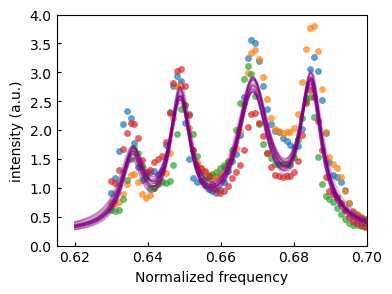

In [23]:
#do the exact same for the second chip
real_data = io_data.load_data('photonic_hamiltonian/data/expdata_chip19_GM0p045.nc')
freq = real_data['normf'].to_numpy()
intensity = np.array([real_data[name].to_numpy() for name in ['y1', 'y2', 'y3', 'y4']])
idata = az.from_netcdf('photonic_hamiltonian/data/idata_chip19_GM0p045.nc')


#-------------
summary = az.summary(idata, round_to=8)
display(summary)
#plot data with the fitting curve
u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4, sigma_y =zip(\
    summary['mean'].values-summary['sd'].values, summary['mean'].values+summary['sd'].values)
fig,ax = plt.subplots(1,1,figsize=(4,3))
ax.set_xlabel("Normalized frequency")
ax.set_ylabel("intensity (a.u.)")
ax.set_xlim([0.615,0.70])
ax.set_ylim([0,4.0])
ax.tick_params(axis="both",direction='in',length=3)
ax.plot(freq, intensity.T, 'o',alpha  = 0.7, markersize = 5, markeredgecolor='none' )
for i in range(0,25):
    theta = [random.uniform(x[0],x[1]) for x in [u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4]]
    model_predictions = Model.prediction_model(theta, np.linspace(0.62,0.70,200))

    ax.plot(np.linspace(0.62,0.70,200), model_predictions,'k', linewidth = 1,color = 'purple',alpha = 0.3)

plt.savefig('photonic_hamiltonian/data/fit_chip19_GM0p045.pdf', dpi = 300,bbox_inches = 'tight')

#### Plot results
We get pretty reasonable results from the model. With sampled data, we can do a lot of analysis. The following cells show some pair plots to visualize the posterior for different parameter groups.

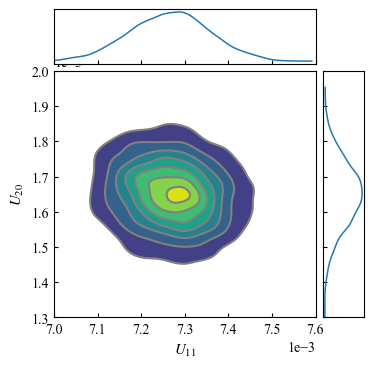

In [24]:
# plot the interseted coupling strength, u11 and u20
import arviz.labels as azl
labeller = azl.MapLabeller(var_name_map={"u11": r"$U_{11}$","u20": r"$U_{20}$"})
from matplotlib import rcParams
font = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size' : 13,
         }
confont = {
           'font.family' : 'serif',
           'mathtext.fontset':'stix',
           'font.serif':'Times New Roman',
           'font.size' : 10,
         }
rcParams.update(confont)
ff = az.plot_pair(idata,var_names=["u11", "u20"], labeller =labeller, marginals=True,figsize=(4, 4),kind='kde')
ff[1,0].set_xlim([0.007,0.0076])
ff[1,0].set_ylim([0.0013,0.0020])
ff[1,0].tick_params(axis="both",direction='in',length=3)
ff[0,0].tick_params(axis="both",direction='in',length=3)
ff[1,1].tick_params(axis="both",direction='in',length=3)
ff[1,0].ticklabel_format(style="sci", axis='both', scilimits=(0,0))
#ff.set_xlable('5')

plt.savefig('photonic_hamiltonian/data/Upair_chip19_GM0p045.pdf', dpi = 300,bbox_inches = 'tight')
#plt.savefig('photonic_hamiltonian/data/Upair_chip18_GM0p0625.pdf', dpi = 300,bbox_inches = 'tight')
# az.to_netcdf(idata,'photonic_hamiltonian/data/idata_chip19_GM0p04.nc')

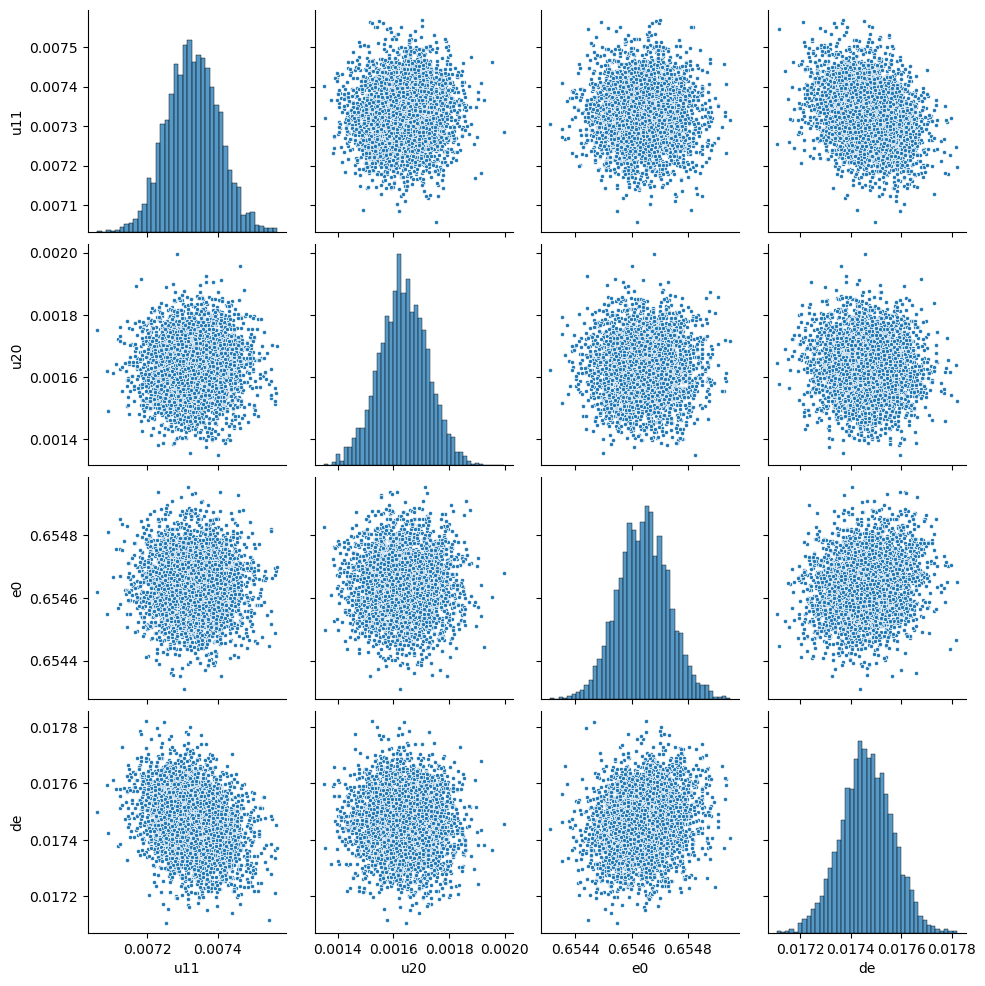

In [14]:
# covarience between coupling strength and energy
P_couple =["u11", "u20", "e0", "de"]
best_fit_sel1 = idata.posterior.to_dataframe().loc[:, P_couple]
sns.pairplot(best_fit_sel1, markers='.');

The uncorrelation of these coupling strengths and energies shown in the above pair plot matches with our expectation since these parameters are physically independent.

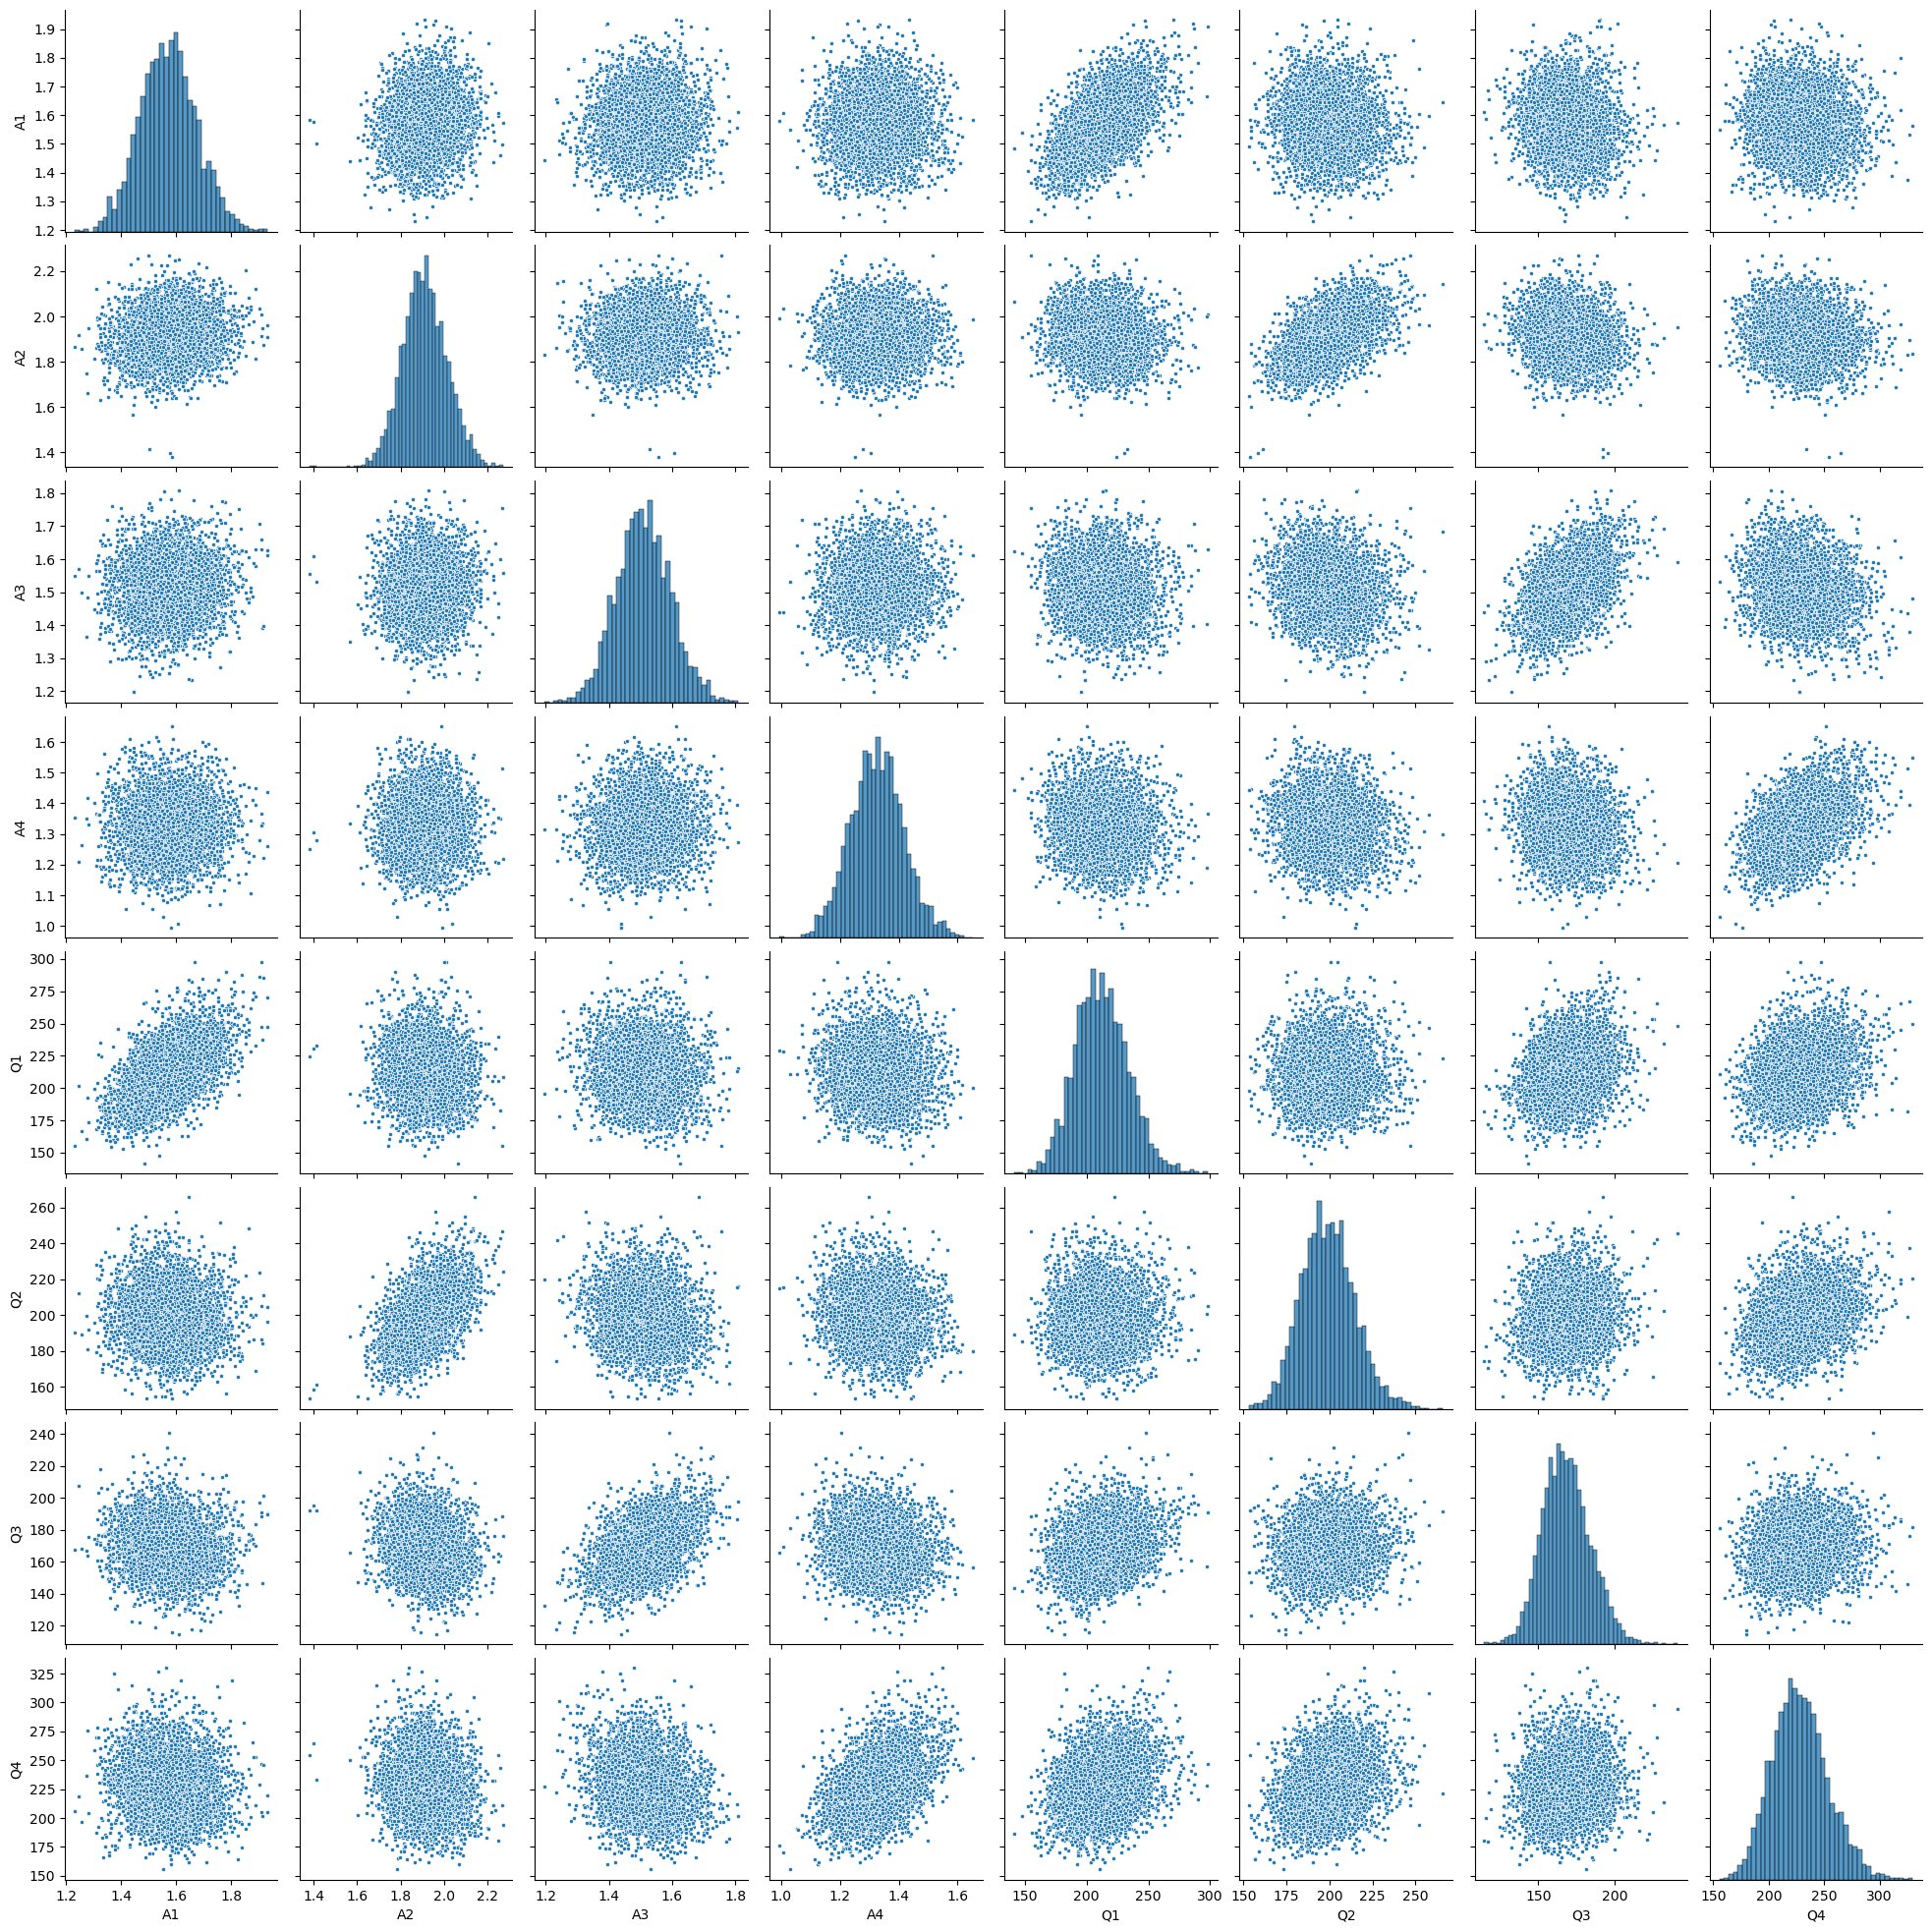

In [17]:
# peak height and peak width covarience
AandQ =["A1", "A2", "A3", "A4", "Q1", "Q2", "Q3", "Q4"]
best_fit_sel2 = idata.posterior.to_dataframe().loc[:, AandQ]
sns.pairplot(best_fit_sel2, markers='.');

#### More calculation on different k points

We have evaluated the performance of our model on different k-point spectra and obtained well-fitted spectra with reasonable coupling terms. The figure below displays the mean and standard deviation of $U_{11}$ and $U_{20}$ at three different k-points. We expected that the values of these coupling terms are universal across different k-points in momentum space. Indeed, our inferred results clearly shows this universality. Thus, this is a strong evidence for the validity and robustness of our model and parameter estimation.

![title](reference_img/u11_vs_k.png)
![title](reference_img/u20_vs_k.png)